In [9]:
import os
# run before import keras to select gpu to use.
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import glob
import pickle
import numpy as np
from tqdm import tqdm
from natsort import natsorted
import matplotlib.pyplot as plt
from PIL import Image
import pickle
import time

import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [10]:
!pip install wandb -qqq
import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [11]:
def load_pkl(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)
X_train = load_pkl("./instruction_representation_X_train.pkl")
X_train_99 = load_pkl("./instruction_representation_X_train_99.pkl")
X_test = load_pkl("./instruction_representation_X_test.pkl")
X_test_99 = load_pkl("./instruction_representation_X_test_99.pkl")
y_train = load_pkl("./instruction_representation_y_train.pkl")
y_test = load_pkl("./instruction_representation_y_test.pkl")

# 9228 = 769 * 12. (769 tasks, 12 demos.)
# 888 = 74 * 12. (74 tasks, 12 demos.)
# 125, 125, 3:  image_size
# 768: language_size
assert X_train.shape == (769 * 12, 125, 125, 3)
assert y_train.shape == (769 * 12, 1, 128)
assert X_test.shape == (74 * 12, 125, 125, 3)
assert y_test.shape == (74 * 12, 1, 128)

X_train = X_train.astype("float") / 255
X_train_99 = X_train_99.astype("float") / 255
X_test = X_test.astype("float") / 255
X_test_99 = X_test_99.astype("float") / 255

In [12]:
from wandb.keras import WandbCallback

run = wandb.init(project='Convautoencoder-pretrain_128',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 0.0001,
                     "epochs": 300,
                     "batch_size": 32,
                     "dim": 512
                 })

config = wandb.config

epoch,58
loss,0.00126
val_loss,0.00169
_runtime,808
_timestamp,1619537091
_step,58
best_val_loss,0.00169
best_epoch,56


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


In [14]:
# Setting the model.
class ImagetextAutoencoder(Model):
    """
    layer = tf.layers.conv2d(layer, 16, 5, 2, 'same')
    layer = tf.contrib.layers.layer_norm(layer, activation_fn="elu")
    """
    def __init__(self, dim):
        super(ImagetextAutoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(125, 125, 3)),
            layers.ZeroPadding2D(padding=(3, 3)),
            layers.Conv2D(32, (4, 4), activation='elu', padding='valid', strides=1),
            layers.Conv2D(32, (4, 4), activation='elu', padding='same', strides=2),
            layers.Conv2D(64, (4, 4), activation='elu', padding='same', strides=2),
            layers.Conv2D(128, (4, 4), activation='elu', padding='same', strides=2),
            layers.Conv2D(256, (4, 4), activation='elu', padding='same', strides=2),
            layers.Flatten(),
            layers.Dense(dim)
            ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(8 * 8 * 256),
            layers.Reshape((8, 8, 256)),
            layers.Conv2DTranspose(128, kernel_size=4, strides=2, activation='elu', padding='same'),
            layers.Conv2DTranspose(64, kernel_size=4, strides=2, activation='elu', padding='same'),
            layers.Conv2DTranspose(32, kernel_size=4, strides=2, activation='elu', padding='same'),
            layers.Conv2DTranspose(32, kernel_size=4, strides=2, activation='elu', padding='same'),
            layers.Conv2D(3, (4, 4), activation='sigmoid', padding='valid', strides=1)
        ])
        self.text_encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(256, activation='elu'),
            layers.Dense(512)
            ])
    def call(self, x):
        # print("x_shape", x.shape)
        x, x_diff, text = x[0], x[1], x[2]
        encoded = self.encoder(x)
        x_diff = self.encoder(x_diff)
        text = self.text_encoder(text)

        decoder_input = layers.Concatenate(axis=1)([encoded, text, x_diff])
        
        decoded = self.decoder(decoder_input)
        
        return decoded

# Setting of Model.
# strategy = tf.distribute.MirroredStrategy()
# print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

# with strategy.scope():
model = ImagetextAutoencoder(config.dim)

optimizer = tf.keras.optimizers.Adam(config.learning_rate)
model.compile(optimizer=optimizer, loss=losses.MeanSquaredError())

In [15]:
# Fit model.
callbacks = [
    WandbCallback(),
    EarlyStopping(patience=30, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1)
]
model.fit((X_train, X_train_99 - X_train, y_train), X_train_99, 
            epochs=config.epochs, 
            batch_size=config.batch_size, 
            shuffle=True,
            validation_data=((X_test, X_test_99 - X_test, y_test), X_test_99),
            callbacks=callbacks)
run.finish()

Epoch 1/300
289/289 [==============================] - 13s 39ms/step - loss: 0.0332 - val_loss: 0.0052


wandb: ERROR Can't save model, h5py returned error: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.


Epoch 2/300
289/289 [==============================] - 10s 36ms/step - loss: 0.0049 - val_loss: 0.0039
Epoch 3/300
289/289 [==============================] - 10s 36ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 4/300
289/289 [==============================] - 10s 36ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 5/300
289/289 [==============================] - 10s 36ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 6/300
289/289 [==============================] - 10s 36ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 7/300
289/289 [==============================] - 10s 36ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 8/300
289/289 [==============================] - 10s 36ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 9/300
289/289 [==============================] - 10s 36ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 10/300
289/289 [==============================] - 10s 36ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 11/300
289/289 [==============================] - 10s 36ms/step - 

RuntimeError: release unlocked lock

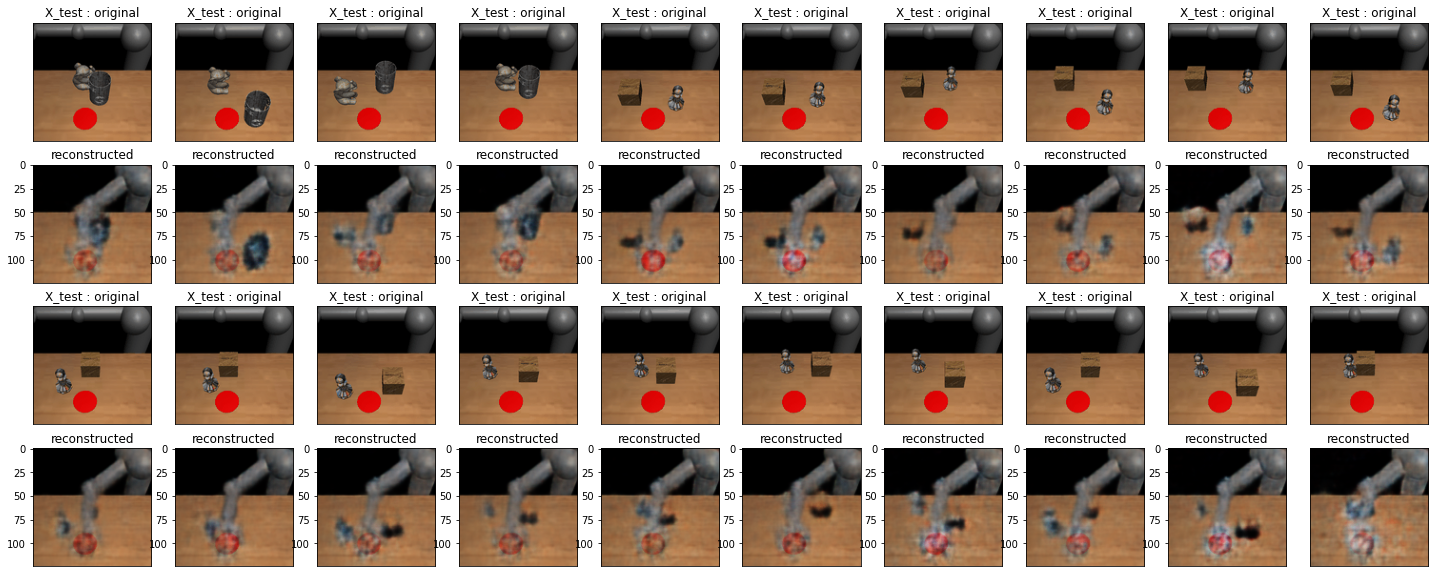

In [17]:
# 可視化
k = 20
input_data = X_test
input_data_99 = X_test_99
input_data_text = y_test
# input_data = X_train
# input_data_99 = X_train_99
# input_data_text = y_train

encoded_imgs = model.encoder(input_data[k:k+20]).numpy()
encoded_imgs_diff = model.encoder(input_data_99[k:k+20] - input_data[k:k+20]).numpy()
encoded_text = model.text_encoder(input_data_text[k:k+20]).numpy()

input_ = np.concatenate([encoded_imgs, encoded_imgs_diff, encoded_text], axis=1)
decoded_imgs = model.decoder(input_).numpy()

import matplotlib.pyplot as plt
n = 10
plt.figure(figsize=(25, 10))
for i in range(n):
    # display original
    ax = plt.subplot(4, n, i + 1)
    plt.imshow(input_data[k+i])
    plt.title("X_test : original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(4, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)

        # display original
    ax = plt.subplot(4, n, i + 1 + 2 * n)
    plt.imshow(input_data[k + i + n])
    plt.title("X_test : original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(4, n, i + 1 + 3 * n)
    plt.imshow(decoded_imgs[i + n])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    
ax.get_yaxis().set_visible(False)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


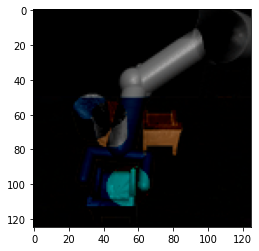

In [18]:
plt.imshow(X_train_99[0] - X_train[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


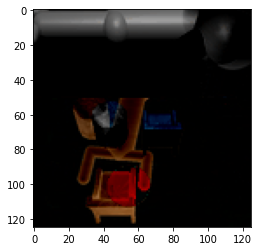

In [21]:
plt.imshow(X_train[0] - X_train_99[0])

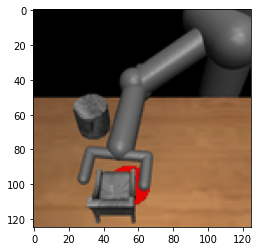

In [19]:
plt.imshow(X_train_99[0])

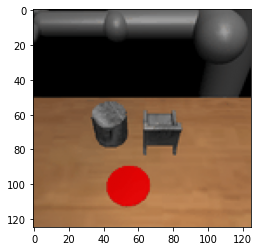

In [20]:
plt.imshow(X_train[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


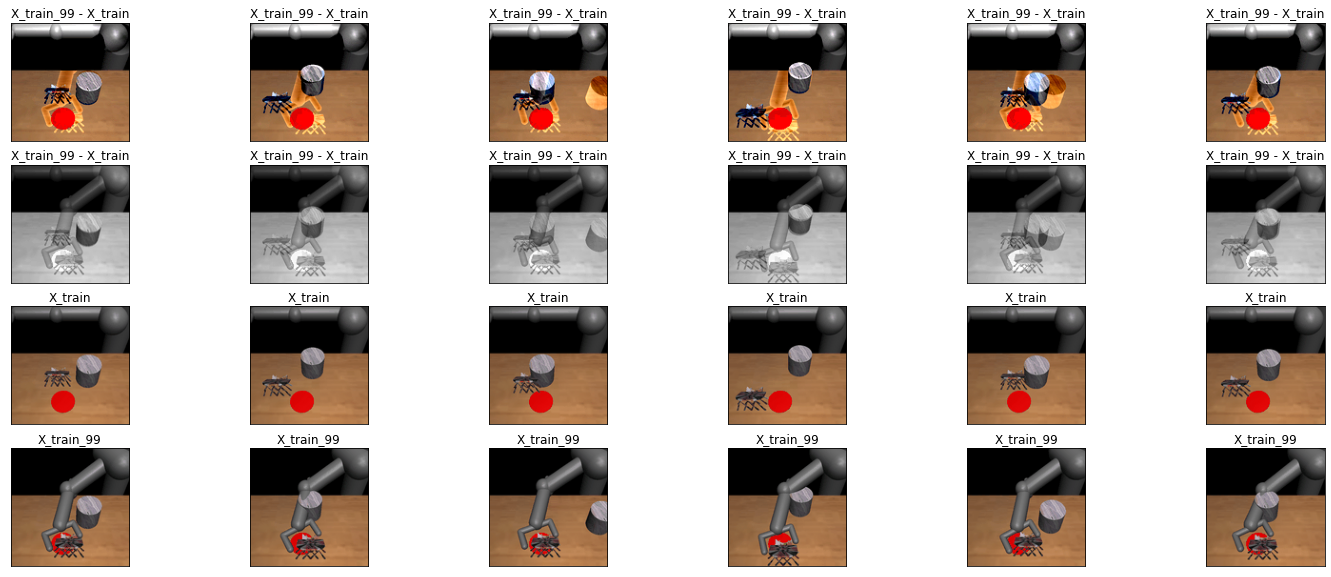

In [43]:
k = 30
n = 6
plt.figure(figsize=(25, 10))
for i in range(n):
    # display original
    ax = plt.subplot(4, n, i + 1)
    plt.imshow(X_train[k + i] - X_train_99[k + i] + X_train[k + i])
    plt.title("X_train_99 - X_train")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(4, n, i + 1 + n)
    plt.imshow(X_train_99[k + i][:,:,0] + X_train[k + i][:,:,0])
    plt.title("X_train_99 - X_train")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display original
    ax = plt.subplot(4, n, i + 1 +  2 * n)
    plt.imshow(X_train[k + i][:,:,:])
    plt.title("X_train")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display original
    ax = plt.subplot(4, n, i + 1 + 3 * n)
    plt.imshow(X_train_99[k + i])
    plt.title("X_train_99")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()